In [1]:
%load_ext autoreload
%autoreload 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from multiprocess import Pool, cpu_count

from fem2D import *
from squareMesh import squareMesh


nprocesses = cpu_count()
print(f"Code parallelized with {nprocesses} processes.")

Code parallelized with 12 processes.


In [15]:
# chargement du maillage

eraseCurrentMesh()

N = 2       # elements order

L = 100.0   # square size
dx = 5.0    # elements size
elements, nodes = squareMesh(L,dx,N)
Δx = dx/(N+1) 

dof = len(nodes)
print(f"{dof=}")

dof=1681


<AxesSubplot:>

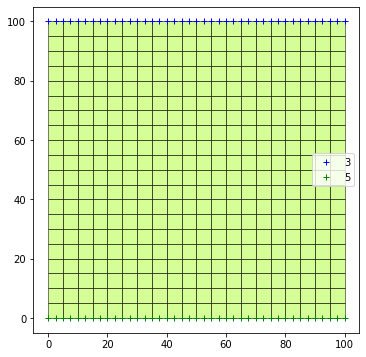

In [16]:
plotMesh(elements, nodes, [3,5]) 

In [17]:
# Chargement des points/poids d'intégration de GLL + dérivée des interpolateurs lagrangiens sur ces points

N = int(np.sqrt(len(elements[0].nodes))) - 1

if N == 1:
    raise(Exception("Please use classical FEM (linear) for order 1 mesh"))

xi,w,dh = readGLL(N)

print(f"{N=}")
print(f"{xi=}")

N=2
xi=array([-1.,  0.,  1.])


In [18]:
# Pour chaque élément calcul:
# - du jacobien
# - de l'inverse de la matrice jacobienne
# La transformation depuis un élément quelconque vers l'élément de référence est l'interpolation bilinéaire

duphi = shapeFunctions["P1"]["duphi"]
dvphi = shapeFunctions["P1"]["dvphi"]

def computeJacobian(e):
        
    coords = e.getCoords()
    X, Y = coords[:,0], coords[:,1]
    
    Je11 = np.zeros((N+1,N+1))
    Je21 = np.zeros((N+1,N+1))
    Je12 = np.zeros((N+1,N+1))
    Je22 = np.zeros((N+1,N+1))
    
    e.detJ = np.zeros((N+1,N+1))
    
    e.iJe11 = np.zeros((N+1,N+1))
    e.iJe21 = np.zeros((N+1,N+1))
    e.iJe12 = np.zeros((N+1,N+1))
    e.iJe22 = np.zeros((N+1,N+1))

    dxdu = interp(duphi, X)
    dxdv = interp(dvphi, X)        
    dydu = interp(duphi, Y)
    dydv = interp(dvphi, Y)
    
    
    for i in range(N+1):
        for j in range(N+1):
            
            Je11[i,j] = dxdu(xi[i], xi[j])
            Je21[i,j] = dxdv(xi[i], xi[j])
            Je12[i,j] = dydu(xi[i], xi[j])
            Je22[i,j] = dydv(xi[i], xi[j])
            
            e.detJ[i,j] = Je11[i,j]*Je22[i,j] - Je21[i,j]*Je12[i,j]
            
            e.iJe11[i,j] =  Je22[i,j]/e.detJ[i,j]
            e.iJe22[i,j] =  Je11[i,j]/e.detJ[i,j]
            e.iJe21[i,j] = -Je21[i,j]/e.detJ[i,j]
            e.iJe12[i,j] = -Je12[i,j]/e.detJ[i,j]
            
    return e
    
with Pool(nprocesses) as p:
    Element.id = 0
    elements = list(tqdm(p.imap(computeJacobian, elements), total=len(elements)))

100%|██████████| 400/400 [00:00<00:00, 715.33it/s]


In [19]:
E = 11       # module d'Young
ν = 0.15     # coefficient de Poisson

# paramètres de Lamé
λ = (E*ν) / ((1+ν)*(1-2*ν))
μ = E / (2*(1+ν))

In [20]:
# calcul des matrices élémentaires

δ = np.eye(N+1)

def computeStiffnes(e):
    
    # KeTemp = np.zeros((N+1,N+1,N+1,N+1))
    e.Ke = np.zeros((2*(N+1)**2,2*(N+1)**2))
    
    Kdxdx = np.zeros((N+1,N+1,N+1,N+1))
    Kdydy = np.zeros((N+1,N+1,N+1,N+1))
    Kdxdy = np.zeros((N+1,N+1,N+1,N+1))
    Kdydx = np.zeros((N+1,N+1,N+1,N+1))
    
    for a in range(N+1):
        for b in range(N+1):
            for c in range(N+1):
                for d in range(N+1):
                       
                        for p in range(N+1):
                            for q in range(N+1):
                                
                                Kdxdx[a,b,c,d] += w[p]*w[q] * (e.iJe11[p,q]*dh[a,p]*δ[b,q] + e.iJe12[p,q]*dh[b,q]*δ[a,p])*(e.iJe11[p,q]*dh[c,p]*δ[d,q] + e.iJe12[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                Kdydy[a,b,c,d] += w[p]*w[q] * (e.iJe21[p,q]*dh[a,p]*δ[b,q] + e.iJe22[p,q]*dh[b,q]*δ[a,p])*(e.iJe21[p,q]*dh[c,p]*δ[d,q] + e.iJe22[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                Kdxdy[a,b,c,d] += w[p]*w[q] * (e.iJe11[p,q]*dh[a,p]*δ[b,q] + e.iJe12[p,q]*dh[b,q]*δ[a,p])*(e.iJe21[p,q]*dh[c,p]*δ[d,q] + e.iJe22[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                Kdydx[a,b,c,d] += w[p]*w[q] * (e.iJe21[p,q]*dh[a,p]*δ[b,q] + e.iJe22[p,q]*dh[b,q]*δ[a,p])*(e.iJe21[p,q]*dh[c,p]*δ[d,q] + e.iJe22[p,q]*dh[d,q]*δ[c,p]) * e.detJ[p,q]
                                
    for i in range(2*(N+1)**2):
        for j in range(2*(N+1)**2):
            
            if i%2 == 0 and j%2 == 0:
                
                a,b = i//2//(N+1), i//2%(N+1)
                c,d = j//2//(N+1), j//2%(N+1)
                
                e.Ke[i,j] = (2*λ+μ)*Kdxdx[a,b,c,d] + μ*Kdydy[a,b,c,d]             
                
            if i%2 == 0 and j%2 != 0:
            
                a,b = i//2//(N+1), i//2%(N+1)
                c,d = (j-1)//2//(N+1), (j-1)//2%(N+1)
                
                e.Ke[i,j] = λ*Kdxdy[a,b,c,d] + μ*Kdydx[a,b,c,d]      
            
            if i%2 != 0 and j%2 == 0:
                    
                a,b = (i-1)//2//(N+1), (i-1)//2%(N+1)
                c,d = j//2//(N+1), j//2%(N+1)
                
                e.Ke[i,j] = λ*Kdydx[a,b,c,d] + μ*Kdxdy[a,b,c,d]             
                
            if i%2 != 0 and j%2 != 0:
            
                a,b = (i-1)//2//(N+1), (i-1)//2%(N+1)
                c,d = (j-1)//2//(N+1), (j-1)//2%(N+1)
                
                e.Ke[i,j] = (2*λ+μ)*Kdydy[a,b,c,d] + μ*Kdxdy[a,b,c,d] 
                                
    return e

# elements = list(tqdm(map(computeStiffnes, elements), total=len(elements)))

with Pool(nprocesses) as p:
    Element.id = 0
    elements = list(tqdm(p.imap(computeStiffnes, elements), total=len(elements)))

100%|██████████| 400/400 [00:00<00:00, 477.72it/s]


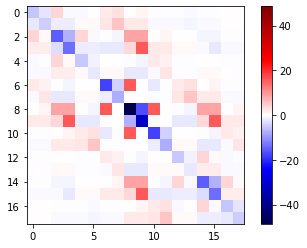

In [21]:
Ke = elements[3].Ke
minKe = min(Ke.min(), -Ke.max())
plt.imshow(Ke, cmap="seismic", vmin=minKe, vmax=-minKe)
plt.colorbar()

In [22]:
# assemblage

K = np.zeros((2*dof,2*dof))
F = np.zeros(2*dof)

for e in tqdm(elements):
    for (i,n1) in enumerate(e.nodes):
        for (j,n2) in enumerate(e.nodes):
            K[2*n1.id,2*n2.id] += e.Ke[2*i,2*j]
            K[2*n1.id+1,2*n2.id] += e.Ke[2*i+1,2*j]
            K[2*n1.id,2*n2.id+1] += e.Ke[2*i,2*j+1]
            K[2*n1.id+1,2*n2.id+1] += e.Ke[2*i+1,2*j+1]
            

100%|██████████| 400/400 [00:00<00:00, 3735.50it/s]


In [56]:
bot, top = 3, 5
ubot1, ubot2 = 0.0, 0.0
utop1, utop2 = 0.0, Δx/100

for n in nodes:
    
    if n.region == bot:
        K[2*n.id,:] = 0
        K[2*n.id, 2*n.id] = 1
        K[2*n.id+1,:] = 0
        K[2*n.id+1, 2*n.id+1] = 1
        F[2*n.id] = ubot1
        F[2*n.id+1] = ubot2
        
    if n.region == top:
        K[2*n.id,:] = 0
        K[2*n.id, 2*n.id] = 1
        K[2*n.id+1,:] = 0
        K[2*n.id+1, 2*n.id+1] = 1
        F[2*n.id] = utop1
        F[2*n.id+1] = utop2


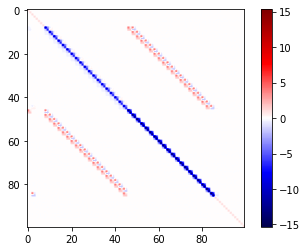

In [57]:
iSubset = 100
minK = min(K[:iSubset, :iSubset].min(), -K[:iSubset, :iSubset].max())
plt.imshow(K[:iSubset, :iSubset], cmap="seismic", vmin=minK, vmax=-minK)
plt.colorbar()

In [58]:
# Résolution du système

U = np.linalg.solve(K, F)

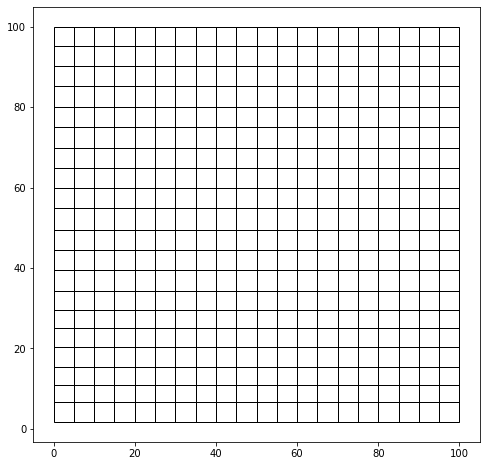

In [59]:
fig, ax = plt.subplots(figsize=(8,8))

plotDeformedMesh(elements, U, ax, s=100)

In [60]:
# extract and plot the displacements on the left side

left = 2

yCoord = []
u1, u2 = [],[]

for n in nodes:
    if n.region == left:
        yCoord.append(n.y)
        u1.append(U[2*n.id])
        u2.append(U[2*n.id+1])

Displacement imposed:
On bot :  [0.0,0.0]
On top :   [0.0,0.016666666666666666]


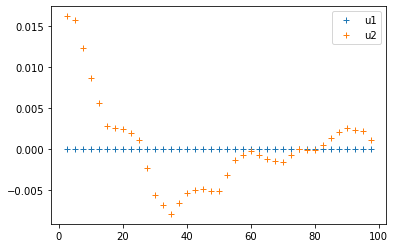

In [61]:
print(f"Displacement imposed:\nOn bot :  [{ubot1},{ubot2}]\nOn top :   [{utop1},{utop2}]")
plt.plot(yCoord, u1, "+",  label="u1")
plt.plot(yCoord, u2, "+", label="u2")
plt.legend()